<a href="https://colab.research.google.com/github/Josecanihuante/DL-workshop-series/blob/master/Densenet1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.models import load_model
import keras.backend as K
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import torch

In [ ]:
n_class = 5

# path to kaggle dataset
root_path = "/content/drive/MyDrive/ArtrosisdeRodilla/KneeXrayData/KneeXrayData/ClsKLData/kneeKL224/"

# list of folders
folder_list = os.listdir(root_path)
image_path_list = []
label_list = []

# for each folder, get the image path and labels
for folder in folder_list:
    for label in range(n_class):
        
        # get all the images path inside the current folder
        image_list = os.listdir(f"{root_path}{folder}/{label}")
        # add to the image path list
        image_path_list += [ f"{root_path}{folder}/{label}/"+ path for path in image_list]
        
        # add labels to the label list
        label_list += [label] * len(image_list)

# convert to dataframe
df_train_kaggle = pd.DataFrame({"filepath" : image_path_list, "label": label_list})

In [ ]:
# train data generator object
train_aug = ImageDataGenerator(rescale=1./255)

# validation data generator object
valid_aug = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_aug.flow_from_dataframe(
dataframe=df_train_kaggle,
directory=None,
x_col="filepath",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(224,224))

Found 9867 validated image filenames.


In [ ]:
!unzip -q -o /content/KneeXray.zip -d /content/

In [ ]:
compi_root_path= "/content/KneeXray/"
df_val_compi = pd.read_csv(compi_root_path + "Train.csv")

# add absolute path to the image names
df_val_compi["filename"] = df_val_compi.filename.apply(lambda x: compi_root_path+"train/" + x)
df_val_compi.head()

In [19]:
# create validation generator
valid_generator = valid_aug.flow_from_dataframe( 
dataframe= df_val_compi,
x_col= "filename",
y_col= "label",
batch_size= 32,
seed= 42,
shuffle= True,
class_mode= "raw",
target_size= (224,224))

Found 7828 validated image filenames.


In [ ]:
import tensorflow.keras as K

initializer = K.initializers.he_normal(seed=32)
input_shape_densenet = (224, 224, 3)

densenet_model = K.applications.DenseNet169(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape_densenet,
    pooling=None
)


densenet_model.trainable = True

for layer in densenet_model.layers:
  if 'conv5' in layer.name:
    layer.trainable = True
  else:
    layer.trainable = False

densenet_model.summary()

input = K.Input(shape=(224, 224, 3))

layer = densenet_model(inputs=input)

layer = K.layers.Flatten()(layer)

layer = K.layers.BatchNormalization()(layer)

layer = K.layers.Dense(units=256,
                        activation='relu',
                        kernel_initializer=initializer
                        )(layer)

layer = K.layers.Dropout(0.4)(layer)

layer = K.layers.BatchNormalization()(layer)

layer = K.layers.Dense(units=128,
                       activation='relu',
                       kernel_initializer=initializer
                       )(layer)

layer = K.layers.Dropout(0.4)(layer)

layer = K.layers.Dense(units=5,
                       activation='softmax',
                       kernel_initializer=initializer
                       )(layer)

model = K.models.Model(inputs=input, outputs=layer)

model.summary()

model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001,decay=0.0001),
            metrics=['accuracy'])




In [15]:
checkpoint_path = '/content/'

my_callbacks = tf.keras.callbacks.ModelCheckpoint(
    '/content',
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None,
    initial_value_threshold=None,
    )

In [16]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes= np.unique(df_train_kaggle.label.values),
                                                 y= df_train_kaggle.label.values)
class_weights = dict(enumerate(class_weights))

In [20]:
history = model.fit(train_generator, epochs=8, validation_data=(valid_generator), callbacks=[my_callbacks], batch_size=32, verbose=1, use_multiprocessing = True,
        workers = -1)

model.load_weights(checkpoint_path)

Epoch 1/8
309/309 [==============================] - 7770s 25s/step - loss: 2.1524 - accuracy: 0.2988 - val_loss: 1.1341 - val_accuracy: 0.5584
Epoch 2/8
309/309 [==============================] - 168s 544ms/step - loss: 1.6560 - accuracy: 0.4273 - val_loss: 0.8652 - val_accuracy: 0.6712
Epoch 3/8
309/309 [==============================] - 168s 545ms/step - loss: 1.4119 - accuracy: 0.4913 - val_loss: 0.6942 - val_accuracy: 0.7487
Epoch 4/8
309/309 [==============================] - 168s 544ms/step - loss: 1.2362 - accuracy: 0.5509 - val_loss: 0.5766 - val_accuracy: 0.8016
Epoch 5/8
309/309 [==============================] - 168s 546ms/step - loss: 1.0933 - accuracy: 0.5912 - val_loss: 0.4843 - val_accuracy: 0.8522
Epoch 6/8
309/309 [==============================] - 168s 545ms/step - loss: 0.9653 - accuracy: 0.6383 - val_loss: 0.4023 - val_accuracy: 0.8885
Epoch 7/8
309/309 [==============================] - 168s 545ms/step - loss: 0.8576 - accuracy: 0.6748 - val_loss: 0.3427 - val_acc

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df_val_compi,
                                   test_size=0.1,
                                   random_state=42,
                                   stratify= df_val_compi.label)

In [24]:
train_generator = train_aug.flow_from_dataframe(
dataframe = X_train,
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(224,224))

Found 7045 validated image filenames.


In [25]:
valid_generator = valid_aug.flow_from_dataframe( 
dataframe=X_test,
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(224,224))

Found 783 validated image filenames.


In [26]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID =valid_generator.n//valid_generator.batch_size

In [27]:
model.fit(
        train_generator,
        steps_per_epoch=STEP_SIZE_TRAIN,
        epochs=10,
        validation_data=valid_generator,
        validation_steps=STEP_SIZE_VALID, callbacks=[my_callbacks])

Epoch 1/10
220/220 [==============================] - 39s 179ms/step - loss: 0.7459 - accuracy: 0.7170 - val_loss: 0.2890 - val_accuracy: 0.9284
Epoch 2/10
220/220 [==============================] - 38s 171ms/step - loss: 0.6763 - accuracy: 0.7425 - val_loss: 0.3010 - val_accuracy: 0.9180
Epoch 3/10
220/220 [==============================] - 37s 170ms/step - loss: 0.6027 - accuracy: 0.7764 - val_loss: 0.3276 - val_accuracy: 0.9141
Epoch 4/10
220/220 [==============================] - 38s 170ms/step - loss: 0.5578 - accuracy: 0.7948 - val_loss: 0.3334 - val_accuracy: 0.9102
Epoch 5/10
220/220 [==============================] - 37s 170ms/step - loss: 0.5165 - accuracy: 0.8084 - val_loss: 0.3340 - val_accuracy: 0.9089
Epoch 6/10
220/220 [==============================] - 38s 171ms/step - loss: 0.4534 - accuracy: 0.8326 - val_loss: 0.3305 - val_accuracy: 0.9049
Epoch 7/10
220/220 [==============================] - 38s 171ms/step - loss: 0.4295 - accuracy: 0.8451 - val_loss: 0.3466 - val_ac

In [28]:
model.load_weights(checkpoint_path)

In [29]:
from sklearn.metrics import precision_recall_curve
target_shape = 224
BATCH_SIZE = 1

# test generator
compi_gen = valid_aug.flow_from_dataframe(dataframe= X_test,
                            x_col= "filename",
                            class_mode=None,
                            target_size= (target_shape, target_shape),
                            shuffle= False,
                            batch_size= BATCH_SIZE
                            )

Found 783 validated image filenames.


In [30]:
predicition_compi = model.predict(compi_gen, steps= compi_gen.n/ BATCH_SIZE, verbose= 1)

783/783 [==============================] - 20s 20ms/step


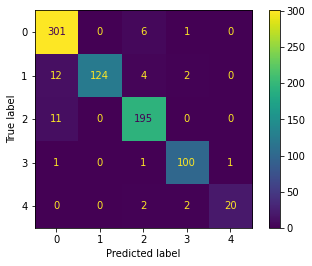

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_prediction_compi =  np.argmax(predicition_compi, axis= 1)
cm = confusion_matrix(X_test.label, class_prediction_compi, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1, 2, 3, 4])
disp.plot()

In [ ]:
model.load_weights(checkpoint_path)


In [ ]:
import cv2

In [41]:
single_test = valid_aug.flow_from_directory('/content/KneeXray/Test.csv.iloc[384]',
                                            target_size = (224, 224),
                                            batch_size = 1,
                                            class_mode = 'categorical') 

FileNotFoundError: ignored

In [39]:
X_test.iloc[23]

filename    /content/KneeXray/train/Image_4157.jpg
label                                            0
Name: 4156, dtype: object